<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [8]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-06-16 05:48:07--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.08s   

2020-06-16 05:48:08 (268 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [9]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [10]:
df.shape

(346, 10)

### Convert to date time object 

In [11]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [12]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [13]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

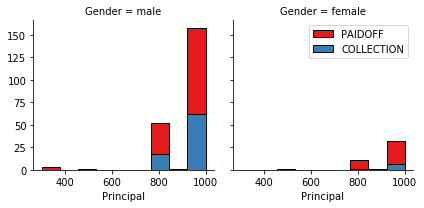

In [14]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

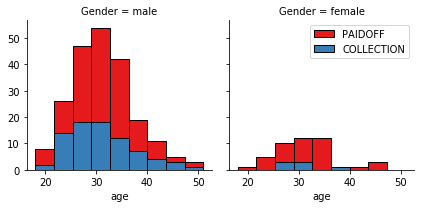

In [15]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

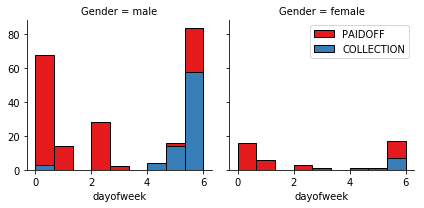

In [16]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [17]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [18]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [19]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [20]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [21]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [22]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [23]:
X = Feature
X[0:5]
X.shape

(346, 8)

What are our lables?

In [24]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [25]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [60]:
#splitting data into training and testing sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 4)

print("trainig data:",x_train.shape,y_train.shape)
print("testing data:",x_test.shape,y_test.shape)

trainig data: (276, 8) (276,)
testing data: (70, 8) (70,)


[0.67142857 0.65714286 0.71428571 0.68571429 0.75714286 0.71428571
 0.78571429 0.75714286 0.75714286 0.67142857]


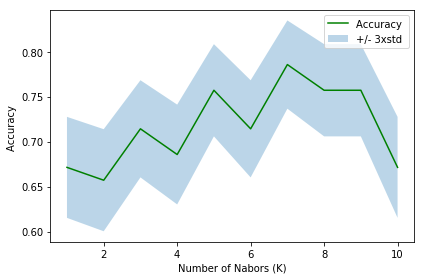

In [61]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

#finding best k
ks = 11
mean_acc = np.zeros(ks-1)
std_acc = np.zeros(ks-1)

for i in range(1,ks):
    
    #training the model
    neigh = KNeighborsClassifier(n_neighbors = i).fit(x_train,y_train)
    yhat = neigh.predict(x_test)
    
    #calculating accuracies
    mean_acc[i-1] = accuracy_score(y_test,yhat)
    
    std_acc[i-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
print(mean_acc)

#plotting for best k
import matplotlib.pyplot as plt
plt.plot(range(1,11),mean_acc,'g')
plt.fill_between(range(1,11),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.30)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()



In [62]:
#so from the plot it seems the best value for k is 7

#training model and predicting values on test data
k = 7
neigh = KNeighborsClassifier(n_neighbors = k).fit(x_train,y_train)
yhat = neigh.predict(x_test)

#Claculating accuracy with different metrics techniques

#0
print("training accuracy:",accuracy_score(y_train,neigh.predict(x_train)))
print("testing accuracy:",accuracy_score(y_test,yhat))


print( "\nThe best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)

#1 Jaccard index
from sklearn.metrics import jaccard_similarity_score
print("\njaccard index accuracy score:",jaccard_similarity_score(y_test,yhat))

#2 f1 score
from sklearn.metrics import classification_report,confusion_matrix
print("\nconfution matrix",confusion_matrix(y_test,yhat))
print(classification_report(y_test,yhat))
clr = classification_report(y_test,yhat).split()
print("Average f1 score",(float(clr[7]) + float(clr[12])) / 2)

#3 log loss this is mainly used in logistic regression

training accuracy: 0.8079710144927537
testing accuracy: 0.7857142857142857

The best accuracy was with 0.7857142857142857 with k= 7

jaccard index accuracy score: 0.7857142857142857

confution matrix [[ 6  9]
 [ 6 49]]
              precision    recall  f1-score   support

  COLLECTION       0.50      0.40      0.44        15
     PAIDOFF       0.84      0.89      0.87        55

   micro avg       0.79      0.79      0.79        70
   macro avg       0.67      0.65      0.66        70
weighted avg       0.77      0.79      0.78        70

Average f1 score 0.655


# Decision Tree

In [63]:
print("trainig data:",x_train.shape,y_train.shape)
print("testing data:",x_test.shape,y_test.shape)

trainig data: (276, 8) (276,)
testing data: (70, 8) (70,)


In [67]:
#finding the best k/max_depth
from sklearn.tree import DecisionTreeClassifier


acc = []
f1 = []
for i in range(1,10):
    dT = DecisionTreeClassifier(criterion = 'entropy',max_depth = i)
    dT.fit(x_train,y_train)
    yhat = dT.predict(x_test)
    acc.append((i,accuracy_score(y_test,yhat)))
    clr = classification_report(y_test,yhat).split()
    f1.append((i,(float(clr[7]) + float(clr[12])) / 2))
print(acc)
print(f1)

#from this both accuracy_score and average f1_score is god for k = 6 or max depth = 6

[(1, 0.7857142857142857), (2, 0.7857142857142857), (3, 0.6142857142857143), (4, 0.6142857142857143), (5, 0.6428571428571429), (6, 0.7714285714285715), (7, 0.7571428571428571), (8, 0.7571428571428571), (9, 0.6571428571428571)]
[(1, 0.44), (2, 0.44), (3, 0.535), (4, 0.535), (5, 0.59), (6, 0.49), (7, 0.485), (8, 0.485), (9, 0.55)]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

In [68]:
#trainng model and predicting values
dT = DecisionTreeClassifier(criterion = 'entropy',max_depth = 6)
#dT
dT.fit(x_train,y_train)
yhat = dT.predict(x_test)

print (yhat [0:5])
print (y_test [0:5])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [69]:
#calculating accuracies with different techniques

#0 simple accuracies
from sklearn.metrics import accuracy_score
print("accuracy score",accuracy_score(y_test,yhat))

#1 jaccard index
from sklearn.metrics import jaccard_similarity_score
print("\njaccard index score",jaccard_similarity_score(y_test,yhat))

#2 f1 score
from sklearn.metrics import classification_report, confusion_matrix
print("\nconfusion matrix\n",confusion_matrix(y_test,yhat))
print("\ncalssification report\n",classification_report(y_test,yhat))
clr = classification_report(y_test,yhat).split()
print("Average f1 score",(float(clr[7]) + float(clr[12])) / 2)

accuracy score 0.7714285714285715

jaccard index score 0.7714285714285715

confusion matrix
 [[ 1 14]
 [ 2 53]]

calssification report
               precision    recall  f1-score   support

  COLLECTION       0.33      0.07      0.11        15
     PAIDOFF       0.79      0.96      0.87        55

   micro avg       0.77      0.77      0.77        70
   macro avg       0.56      0.52      0.49        70
weighted avg       0.69      0.77      0.71        70

Average f1 score 0.49


# Support Vector Machine

In [70]:
from sklearn import svm

#finding best k or kernel for SVM
acc = []
f1 = []

for i in ['linear','rbf','poly','sigmoid']:
    clf = svm.SVC(kernel = i)
    clf.fit(x_train,y_train)
    yhat = clf.predict(x_test)

    acc.append((i,accuracy_score(y_test,yhat)))
    clr = classification_report(y_test,yhat).split()
    f1.append((i,(float(clr[7]) + float(clr[12])) / 2))
print(acc)
print(f1)

#from this we can see that the best k / kernel is radial basis fucntion(rbf)

[('linear', 0.7857142857142857), ('rbf', 0.7428571428571429), ('poly', 0.7714285714285715), ('sigmoid', 0.7428571428571429)]
[('linear', 0.44), ('rbf', 0.575), ('poly', 0.49), ('sigmoid', 0.475)]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamm

In [71]:
#training the model and predicting values


clf = svm.SVC(kernel = 'rbf')
clf.fit(x_train,y_train)
yhat = clf.predict(x_test)

print (yhat [0:5])
print (y_test [0:5])

['COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [72]:
#calculating accuracies with different techniques

print(accuracy_score(y_test,yhat))
print("\njaccard index score",jaccard_similarity_score(y_test,yhat))
print("\nconfusion matrix",confusion_matrix(y_test,yhat))
clr = classification_report(y_test,yhat).split()
print("\nAverage f1 score",(float(clr[7]) + float(clr[12])) / 2)


0.7428571428571429

jaccard index score 0.7428571428571429

confusion matrix [[ 4 11]
 [ 7 48]]

Average f1 score 0.575


# Logistic Regression

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
#finding best k or solver for logistic regression on this data

acc = []
f1 = []
lgl = []

for i in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
        lr = LogisticRegression(C = 0.1,solver = i).fit(x_train,y_train)
        yhat = lr.predict(x_test)
        acc.append((i,accuracy_score(y_test,yhat)))
        clr = classification_report(y_test,yhat).split()
        f1.append((i,(float(clr[7]) + float(clr[12])) / 2))
        yhat_prob = lr.predict_proba(x_test)
        lgl.append((i,log_loss(y_test,yhat_prob)))
print(acc,'\n\n',f1,'\n\n',lgl)
print('\n\n',max(acc,key = lambda x: x[1]))
print('\n\n',max(f1,key = lambda x: x[1]))
print('\n\n',min(lgl,key = lambda x: x[1]))


#from this we can see that logg loss is minimum when the k / solver is sag

[('newton-cg', 0.7714285714285715), ('lbfgs', 0.7714285714285715), ('liblinear', 0.7428571428571429), ('sag', 0.7714285714285715), ('saga', 0.7714285714285715)] 

 [('newton-cg', 0.49), ('lbfgs', 0.49), ('liblinear', 0.515), ('sag', 0.49), ('saga', 0.49)] 

 [('newton-cg', 0.48275353245267294), ('lbfgs', 0.4827539604894662), ('liblinear', 0.4981902487744225), ('sag', 0.48274760379250237), ('saga', 0.48275604325304133)]


 ('newton-cg', 0.7714285714285715)


 ('liblinear', 0.515)


 ('sag', 0.48274760379250237)


In [74]:
#trianing the model and predicting the values

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C = 0.1,solver = 'sag')
lr.fit(x_train,y_train)
yhat = lr.predict(x_test)

print(y_test[0:5])
print(yhat[0:5])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [75]:
#Calculating accuracy with different techniques

#0 simple accuracy
from sklearn.metrics import accuracy_score
print("accuracy score",accuracy_score(y_test,yhat))

#1 jaccard index
from sklearn.metrics import jaccard_similarity_score
print("\njaccard index score",jaccard_similarity_score(y_test,yhat))

#2 f1 score
from sklearn.metrics import classification_report, confusion_matrix
print("\nconfusion matrix\n",confusion_matrix(y_test,yhat))
print("\ncalssification report\n",classification_report(y_test,yhat))
clr = classification_report(y_test,yhat).split()
print("Average f1 score",(float(clr[7]) + float(clr[12])) / 2)

#3 log loss
from sklearn.metrics import log_loss
yhat_prob = lr.predict_proba(x_test)
print('\nLog Loss',log_loss(y_test,yhat_prob))

accuracy score 0.7714285714285715

jaccard index score 0.7714285714285715

confusion matrix
 [[ 1 14]
 [ 2 53]]

calssification report
               precision    recall  f1-score   support

  COLLECTION       0.33      0.07      0.11        15
     PAIDOFF       0.79      0.96      0.87        55

   micro avg       0.77      0.77      0.77        70
   macro avg       0.56      0.52      0.49        70
weighted avg       0.69      0.77      0.71        70

Average f1 score 0.49

Log Loss 0.4827534004961394


# Model Evaluation using Test set

In [82]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [77]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-06-16 06:13:33--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-06-16 06:13:33 (383 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [78]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [79]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
Feature2 = test_df[['Principal','terms','age','Gender','weekend']]
Feature2 = pd.concat([Feature2,pd.get_dummies(test_df['education'])], axis=1)
Feature2.drop(['Master or Above'], axis = 1,inplace=True)
Feature2.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [80]:
X_test1 = Feature2
test_data = preprocessing.StandardScaler().fit(X_test1).transform(X_test1)
test_data


#Predicting values using all the trained models
yhat_knn_test = neigh.predict(test_data)
yhat_dt_test = dT.predict(test_data)
yhat_svm_test = clf.predict(test_data)
yhat_lr_test = lr.predict(test_data)
yhat_prob_lr_test = lr.predict_proba(test_data)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [84]:
#Accuracy of all the models
y_test_data = test_df['loan_status'].values
print(y_test_data.shape)

jaccard = []
f1_scor = []
log_ls = [None,None,None,0]
for i in [yhat_knn_test,yhat_dt_test,yhat_svm_test,yhat_lr_test]:
    jaccard.append(jaccard_similarity_score(y_test_data,i))
    f1_scor.append(f1_score(y_test_data, i, average='weighted'))

log_ls[3] = log_loss(y_test_data,yhat_prob_lr_test)
print(jaccard)
print(f1_scor)
print(log_ls)


report_df = pd.DataFrame(list(zip(jaccard, f1_scor,log_ls)), 
               columns =['Jaccard', 'F1-score','LogLoss'],index = ['KNN','Decision Tree','SVM','LogisticRegression'])
report_df

(54,)
[0.6666666666666666, 0.7222222222222222, 0.7962962962962963, 0.7592592592592593]
[0.6328400281888654, 0.6704776923582364, 0.7583503077293734, 0.6717642373556352]
[None, None, None, 0.47195080843791254]


,Jaccard,F1-score,LogLoss
KNN,0.666667,0.632840,NaN
Decision Tree,0.722222,0.670478,NaN
SVM,0.796296,0.758350,NaN
LogisticRegression,0.759259,0.671764,0.471951


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.67    | 0.63     | NA      |
| Decision Tree      | 0.72    | 0.67     | NA      |
| SVM                | 0.80    | 0.76     | NA      |
| LogisticRegression | 0.76    | 0.67     | 0.47    |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>